## Bloques de testeo x100

me descargué los datos de testeo, usaré mi pathing

basicamente copié y pegué, modifiqué un poco :) 

In [1]:
import os
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_USE_CUDNN_BATCHNORM'] = '0' #aumentacion de gatos :3

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Flatten, Dropout
from tensorflow.keras.layers import concatenate, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

import numpy as np
import math

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
import matplotlib.pyplot as plt


In [2]:

                                            ##################
                                            ### Parámetros ###
                                            ##################

# training parameters
batch_size = 32 #usar múltplos de 

epochs = 201 #### Modificable

data_augmentation = True

# network parameters
num_classes = 10
num_dense_blocks = 4
use_max_pool = False

# DenseNet-BC with dataset augmentation
# Growth rate   | Depth |  Accuracy (paper)| Accuracy (this)      |
# 12            | 100   |  95.49%          | 93.74%               |
# 24            | 250   |  96.38%          | requires big mem GPU |
# 40            | 190   |  96.54%          | requires big mem GPU |

growth_rate = 12 #cuanto mapas de caract. sumo 
depth = 100 #Modificable
num_bottleneck_layers = (depth - 4) // (2 * num_dense_blocks) #no meter mano

num_filters_bef_dense_block = 2 * growth_rate
compression_factor = 0.3 #cuanta info voy perdiendo   probar valores a ver si cambiar a 0.3-0.5-0.7

IDEA_1 de carga

In [3]:


# path = '/home/cursos/ima543_2025_1/ima543_share/Datasets/FER/' 
path = 'FER/'

# train_dataset = image_dataset_from_directory(directory=path +'train',
#                                              color_mode='grayscale',
#                                              seed=10,
#                                              image_size=(256,256),
#                                              batch_size=128,
#                                              label_mode='categorical'
#                                              )

test_dataset = image_dataset_from_directory(directory=path +'test',
                                             color_mode='grayscale',
                                             seed=11,
                                             image_size=(256,256),
                                             batch_size=128,
                                             label_mode='categorical'
                                             )

clases = test_dataset.class_names  # ANTES DE NORMALIZAR
norm_layer = Rescaling(1./255)

# normalizar
# train_dataset = train_dataset.map(lambda x,y: (norm_layer(x),y))
test_dataset = test_dataset.map(lambda x,y: (norm_layer(x),y))



Found 7178 files belonging to 7 classes.


IDEA_2 de carga

In [ ]:
def extraer_imagenes(directorio,tamanio): # Directorio con los datos
    """ La función recibe el directorio que tiene los datos. Las imagenes son guardadas en la lista "imagenes" y la clasificación
    en la lista "clases". Cuando se recorre una carpeta con imágenes registrará en la lista "clases" un número de clasificación
    como tantos elementos hay en la carpeta. Normaliza las imágenes y devuelve las matrices listas para jugar.
    
    """
    clases = []
    imagenes = []
    lista_carpetas = os.listdir(directorio)
    # Recorrer
    k = 0
    for carpeta_clase in lista_carpetas:
        for foto in os.listdir(directorio+'/'+carpeta_clase):
            imagen = image.load_img(directorio+'/'+carpeta_clase+'/'+foto, color_mode='grayscale',target_size=tamanio)  # Cada imagen guardada
            imagenes.append(np.array(imagen))       # Registra el número de carpeta al que pertence
            clases.append(k)
        k+=1
    # Conversión a numpy
    X_train = np.array(imagenes, dtype=np.float32)
    # print(X_train.shape)
    clases = np.array(clases)

    # Formato
    image_size = X_train.shape[1]
    canales= tamanio[2]
    X_train = np.reshape(X_train, [-1, image_size, image_size, canales])
    # print(X_train.shape)
    
    # Normalizar
    X_train = X_train / 255
    # print(X_train.shape)
    y_train = to_categorical(clases)
    return X_train, y_train

path_2 = 'FER/test'
# path_1 = '/home/cursos/ima543_2025_1/ima543_share/Datasets/FER/train' 
# path_2 = '/home/cursos/ima543_2025_1/ima543_share/Datasets/FER/test' 

# X_train, y_train = extraer_imagenes(path_1,tamanio=(256,256,1))
X_test, y_test = extraer_imagenes(path_2,tamanio=(256,256,1))

input_shape = X_test.shape[1:]

(7178, 256, 256)
(7178, 256, 256, 1)
(7178, 256, 256, 1)


In [18]:
print(X_test.shape)
print(y_test.shape)

(7178, 256, 256, 1)
(7178, 7)


In [19]:
input_shape

(256, 256, 1)

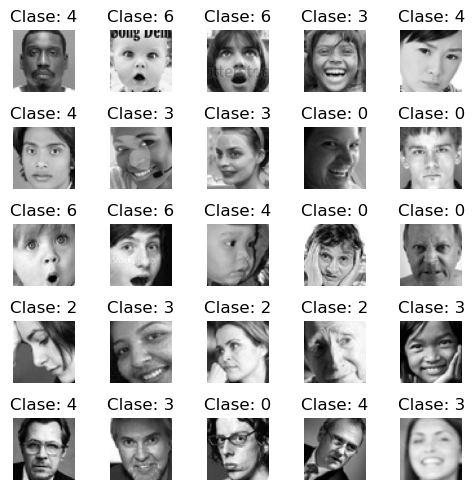

In [ ]:
# Obtener índices aleatorios (usando X_test.shape[0])
indexes = np.random.randint(0, X_test.shape[0], size=25)

# Extraer imágenes y etiquetas correctamente
images = X_test[indexes]  # Imágenes reales
labels = np.argmax(y_test[indexes], axis=1)  # Convertir one-hot a números (ej: [0, 1, 2])

# Graficar
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    plt.title(f'Clase: {labels[i]}')
    plt.imshow(images[i], cmap='gray')  # Mostrar la imagen correcta
    plt.axis('off')
plt.tight_layout()
plt.show()

 



In [21]:
X_test[1:10].shape

(9, 256, 256, 1)

In [18]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [21]:
# start model definition
# densenet CNNs (composite function) are made of BN-ReLU-Conv2D
inputs = Input(shape=input_shape)
x = BatchNormalization()(inputs)
x = Activation('relu')(x)
x = Conv2D(num_filters_bef_dense_block,kernel_size=3,padding='same',kernel_initializer='he_normal')(x) #he_normal segun el articulo da más estabilidad, pero se puede cambiar
x = concatenate([inputs, x])

# stack of dense blocks bridged by transition layers
for i in range(num_dense_blocks):
    # a dense block is a stack of bottleneck layers
    for j in range(num_bottleneck_layers):
        y = BatchNormalization()(x)
        y = Activation('relu')(y)
        y = Conv2D(4 * growth_rate,kernel_size=1,padding='same',kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)  #Evitarlo cuando tenga aumentación de datos
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(growth_rate,kernel_size=3,padding='same',kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        x = concatenate([x, y])

    # no transition layer after the last dense block
    if i == num_dense_blocks - 1:
        continue

    # transition layer compresses num of feature maps and reduces the size by 2
    num_filters_bef_dense_block += num_bottleneck_layers * growth_rate
    num_filters_bef_dense_block = int(num_filters_bef_dense_block * compression_factor)
    y = BatchNormalization()(x)
    y = Conv2D(num_filters_bef_dense_block,kernel_size=1,padding='same',kernel_initializer='he_normal')(y)
    if not data_augmentation:
        y = Dropout(0.2)(y)
    x = AveragePooling2D()(y)


# add classifier on top
# after average pooling, size of feature map is 1 x 1
x = AveragePooling2D(pool_size=4)(x) #se puede jugar
y = Flatten()(x)
outputs = Dense(num_classes,kernel_initializer='he_normal',activation='softmax')(y)

# instantiate and compile model
# orig paper uses SGD but RMSprop works better for DenseNet
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer=RMSprop(1e-3),metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization_100 (Batch  (None, 256, 256, 1)  4          ['input_2[0][0]']                
 Normalization)                                                                                   
                                                                                                  
 activation_97 (Activation)     (None, 256, 256, 1)  0           ['batch_normalization_100[0][0]']
                                                                                            

In [ ]:
# prepare model model saving directory
save_dir = os.path.join(os.getcwd(), 'saved_models_'+ str(epochs) +'_epocas')
model_name = 'cifar10_densenet_model.{epoch:02d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# prepare callbacks for model saving and for learning rate reducer
checkpoint = ModelCheckpoint(filepath=filepath,monitor='val_acc',verbose=2,save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0,patience=5,min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

import time 

start=time.time()

# run training, with or without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,
              validation_data=(x_test, y_test),shuffle=True,callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # preprocessing  and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)

    steps_per_epoch = math.ceil(len(x_train) / batch_size)
    # fit the model on the batches generated by datagen.flow().
    model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),verbose=2,epochs=epochs,
              validation_data=(x_test, y_test),steps_per_epoch=steps_per_epoch,callbacks=callbacks)

fin=time.time()
print('(RUNNING TIME: ' + str(fin-start) )
# score trained model
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])